# Capstone Project

## Introduction

How do nearby venues impact the house prices in London?

If an individual was looking to make a house purchase in London UK, they may wish to consider how local venues impact the house price. While some may be obvious, for example, living near a night club would have an adverse impact, others maybe less clean-cut.

This analysis aims to quantify and rank the impact of various venue types within a set proximity of a property. This should allow the purchaser to make a more informed decision. For example, is a property over or undervalued? What impact will local developments have on the future house price.

## Data

#### Data Sources

1 London house price data is published by the HM Land Registry on http://publicdata.landregistry.gov.uk/ each month. It provides average house prices for all counties in the UK. 

2 Local venue information for each London Borough is captured using the Foursquare API. 

##### 1. HM Land Registry

The house price data will contains over 20 years of historical data that is not required for this analysis. I will exclude that along with non-London counties. Latitude and Longitude data will need to be added using the Geopy library.


In [94]:
#Install libraries
#!pip install pandas
import pandas as pd
import numpy as np
import requests # library to handle requests
import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

!pip install sklearn
from sklearn import linear_model 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt # plotting library
# backend for rendering plots within the browser
%matplotlib inline 

Solving environment: ...working... done

# All requested packages already installed.



In [3]:
#Gather UK average house price data 
df = pd.read_csv("http://publicdata.landregistry.gov.uk/market-trend-data/house-price-index-data/Average-prices-2019-01.csv")
#df = pd.read_csv("http://publicdata.landregistry.gov.uk/market-trend-data/house-price-index-data/UK-HPI-full-file-2019-01.csv")
print(df.shape)

#Remove historical data
df= df[df['Date']==df['Date'].max()]

#remove unneeded columns
df.drop(columns=['Date','Monthly_Change','Annual_Change','Average_Price_SA'], inplace=True)
df.dropna(inplace=True)
print(df.shape)

#Exclude not London boroughs
#Area code - Code of geography (Country, Regional, County/Unitary/District Authority and London Borough)
included_areas = ['E09']
for area in included_areas:
    df = df[df['Area_Code'].str.slice(stop=3)==area]

#df = df[(df['Region_Name']=="City of Westminster")]
print(df.shape)

(125874, 7)
(441, 3)
(33, 3)


In [4]:
#Add lontitude and lattitude data
addresses = df['Region_Name']
latitude = []
longitude = []

for address in addresses:
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address+", London, UK")
    try:
        latitude.append(location.latitude)
        longitude.append(location.longitude)
    except:
        latitude.append(0)
        longitude.append(0)
        
df['Latitude']= latitude
df['Longitude']= longitude

In [5]:
#remove regions that location information was not available
df = df[(df['Latitude']!=0)| (df['Longitude']!=0)]
print(df.shape[0])
df.head()

33


,Region_Name,Area_Code,Average_Price,Latitude,Longitude
125514,City of Westminster,E09000033,959466.0747,51.497321,-0.137149
125524,City of London,E09000001,868257.9880,51.515618,-0.091998
125525,Barking and Dagenham,E09000002,299399.3694,51.554117,0.150504
125526,Barnet,E09000003,516915.9846,51.648784,-0.172913
125527,Bexley,E09000004,341059.9194,51.441679,0.150488


##### 2. Foursquare

Venue data from Foursquare is received in JSON format which will need to be flattened.

In [6]:
CLIENT_ID = 'QKP4KVQQZPVXMOKNIXHGQAT1E2IJZCHQPFB4XJGP3MC0CFUO' # your Foursquare ID
CLIENT_SECRET = '1N5BIRBR1EA5CO1QFMNHU1241SOFM5KJLLQRJGMDC0NOYWPH' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 300 # limit of number of venues returned by Foursquare API
radius = 1000 # define radius
categoryId = ''

In [7]:
#What are the most popular places nearby?

def getNearbyVenues(names, latitudes, longitudes, avg_price, radius=1000):
    
    
    region_list = []
    price_list = []
    
    for name, lat, lng, price in zip(names, latitudes, longitudes, avg_price):
                    
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(    
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            categoryId)
        
        #print(url) 
        
        # make the GET request
        results = requests.get(url).json()["response"]
        
        #flatten JSON file
        resultsVen = json_normalize(results['venues'])
        resultsCat = json_normalize(data=results['venues'], record_path=['categories'], record_prefix='cat_', errors='ignore')
        resultsVenCat = pd.concat([resultsVen, resultsCat], axis=1)
        resultsVenCat = resultsVenCat[['name','location.distance','location.formattedAddress','location.lat','location.lng','cat_name']]
        
        #Add region name and average price 
        for i in range(0,resultsVen.shape[0]):
            region_list.append(name)
            price_list.append(price)
        
        region_list = pd.DataFrame(region_list, columns=['Region Name'])
        price_list = pd.DataFrame(price_list, columns=['Region Avg Price'])
        
        nearbyVenues = pd.concat([region_list, price_list, resultsVenCat], axis=1)

    return(nearbyVenues)

In [8]:
london_venues = pd.DataFrame()

#request venue information for each region and store in regions_venues
for region in df['Region_Name'].unique():
    region_venues = df[df['Region_Name']==region]
    london_venues = london_venues.append((getNearbyVenues(names=region_venues['Region_Name'],
                                                  latitudes=region_venues['Latitude'],
                                                  longitudes=region_venues['Longitude'],
                                                  avg_price=region_venues['Average_Price'])),ignore_index=True)
    
#rename columns
london_venues.rename(columns={'name':'Venue Name',
                          'location.distance':'Venue Distance',
                          'location.formattedAddress':'Venue Address',
                          'location.lat':'Venue Lat',
                          'location.lng':'Venue Lng',
                          'cat_name':'Venue Category'}, inplace=True)

print(london_venues.shape)
london_venues.head()

(5014, 8)


,Region Name,Region Avg Price,Venue Name,Venue Distance,Venue Address,Venue Lat,Venue Lng,Venue Category
0,City of Westminster,959466.0747,Little Waitrose & Partners,13,"[62 Victoria St, Greater London, SW1E 6QP, Uni...",51.497443,-0.137177,Grocery Store
1,City of Westminster,959466.0747,Labour Party HQ,61,"[105 Victoria St (Southside), London, Greater ...",51.496948,-0.137801,Non-Profit
2,City of Westminster,959466.0747,Edelman UK,2,"[105 Victoria St. (Buckingham Gate), London, G...",51.497304,-0.137162,Office
3,City of Westminster,959466.0747,Boots,20,"[107 Victoria Street, London, Greater London, ...",51.497249,-0.137414,Pharmacy
4,City of Westminster,959466.0747,All Bar One,13,"[58 Victoria St, Victoria, Greater London, SW1...",51.497418,-0.137043,Bar


In [9]:
#Drop rows where venue category is unavailable
london_venues.dropna(subset=['Venue Category'],inplace=True)
london_venues.shape

(4787, 8)

#### 2.3 Feature Selection

The venue categorisations captured through the Foursquare API will be used as a feature set. To prepare this I will need to aggregate the data by London Borough using the feature set as column headers.

In [10]:
# one hot encoding
london_onehot = pd.get_dummies(london_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
london_onehot['Average Price'] = london_venues['Region Avg Price'] 
london_onehot['Region Name'] = london_venues['Region Name'] 

#Reorder headings
fixed_columns = [london_onehot.columns[-1]] + [london_onehot.columns[-2]] + list(london_onehot.columns[:-2])
london_onehot = london_onehot[fixed_columns]

#Group by London Borough
df1 = london_onehot.groupby(['Region Name','Average Price']).sum()
df1.reset_index(inplace=True)
df1.head()

,Region Name,Average Price,Accessories Store,Adult Education Center,Advertising Agency,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,...,Warehouse,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit
0,Barking and Dagenham,299399.3694,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
1,Barnet,516915.9846,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Bexley,341059.9194,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,Brent,476933.0759,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Bromley,443289.1746,2,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,4,0,0


In [11]:
#Create dataframe of feature list
df_features = pd.DataFrame(df1.columns)
df_features = df_features.iloc[2:df1.shape[1], :]
df_features.reset_index(inplace=True)

Now we have the dataset in the required format we can run our analysis.

## Methodology & Analysis

We need to determine which feature/venue has the biggest impact on the house price but first let's see whether just simply increasing the number of nearby venues results in increased property value.

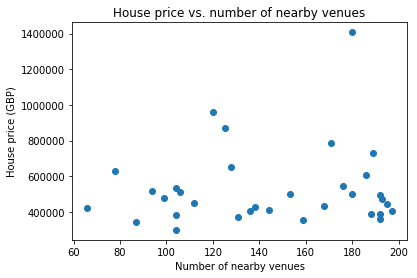

In [12]:
#Count the number of venues nearby venues in each region 
venue_count = london_venues.groupby(['Region Name','Region Avg Price']).count()
venue_count.reset_index(inplace=True)
venue_count = venue_count[['Region Name','Region Avg Price','Venue Category']]
venue_count.sort_values(by=['Venue Category'],inplace=True)

#create scatter plot of house price against number of nearby venues 
plt.scatter(venue_count['Venue Category'],venue_count['Region Avg Price'])
plt.title('House price vs. number of nearby venues')
plt.xlabel('Number of nearby venues')
plt.ylabel('House price (GBP)')
plt.show()

In [13]:
venue_count.corr()

,Region Avg Price,Venue Category
Region Avg Price,1.000000,0.094849
Venue Category,0.094849,1.000000


The scatter plot and 'corr' function shows there is no correlation between house price and the number of nearby venues. 

Now let's determine which venue has the most significant impact on house prices. We can do this using a multivariate linear regression algorithm. I will split the dataset so we can later test the accuracy of the model.

In [38]:
#Set venues as features
X = df1.iloc[:, 2:df1.shape[1]]
#Set price as result(y)
y=df1[['Average Price']]

#Split data in to train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [39]:
regr = linear_model.LinearRegression()

#Fit data
regr.fit(X_train, y_train)

#Add feature labels and sort
coefs = pd.DataFrame(regr.coef_).T
df_coef = pd.concat([df_features, coefs],axis=1,ignore_index=True)
df_coef.drop(columns=0, inplace=True)
df_coef.rename(columns={1:'Venue Category',2:'Coefficient'}, inplace=True)
df_coef.sort_values(by=['Coefficient'],inplace=True)

#print ('Coefficients: ', regr.coef_)
print ('Intercept: ',regr.intercept_)

Intercept:  [329913.24510133]


In [127]:
pd.set_option('display.max_rows', 100)
df_coef

,Venue Category,Coefficient
329,Pub,-14322.106388
183,Government Building,-11803.943508
112,Convenience Store,-11349.390767
234,Light Rail Station,-10748.958317
148,Farm,-10366.136060
282,Nightclub,-9823.630359
165,Food Truck,-9646.332521
351,Sandwich Place,-8933.487058
362,Shopping Mall,-8909.156180
14,Asian Restaurant,-8595.050312


The Y intercept is £329k. This means that if a house was placed with no nearby venues, the model would predict the house value to be £329k. The coefficients listed above show the impact of each venue type. 

In [40]:
y_hat= regr.predict(X_test)
print("Mean absolute error score: %f" % mean_absolute_error(y_test, y_hat))
print("R2 score: %f" % r2_score(y_test, y_hat))

Mean absolute error score: 99508.382253
R2 score: 0.485244


Running the model on the test set reveals positive but not highly accurate results. Let's reviewer further.

In [87]:
#Create Actual vs Predicted comparison table
y_hat_= pd.DataFrame(y_hat, columns=['Predicted Price'])
y_compare = y_test.merge(df1)
y_compare = y_compare[['Region Name','Average Price']]
y_compare = y_compare.merge(y_hat_,left_index=True, right_index=True)
y_compare.rename(columns={'Average Price':'Actual Price'}, inplace = True)

#Add variance column
y_compare['Variance']=y_compare['Actual Price']-y_compare['Predicted Price']
y_compare

,Region Name,Actual Price,Predicted Price,Variance
0,City of London,868257.9880,705580.085188,162677.902812
1,Newham,357611.8565,399827.805341,-42215.948841
2,Havering,373653.0357,567197.298120,-193544.262420
3,Hammersmith and Fulham,732205.7884,648444.512161,83761.276239
4,Lambeth,502320.8359,670847.609717,-168526.773817
5,Harrow,452046.1561,400776.455575,51269.700525
6,Wandsworth,606479.4057,590776.813608,15702.592092
7,Hillingdon,413037.5426,364909.279216,48128.263384
8,Kingston upon Thames,471658.6030,601407.323148,-129748.720148


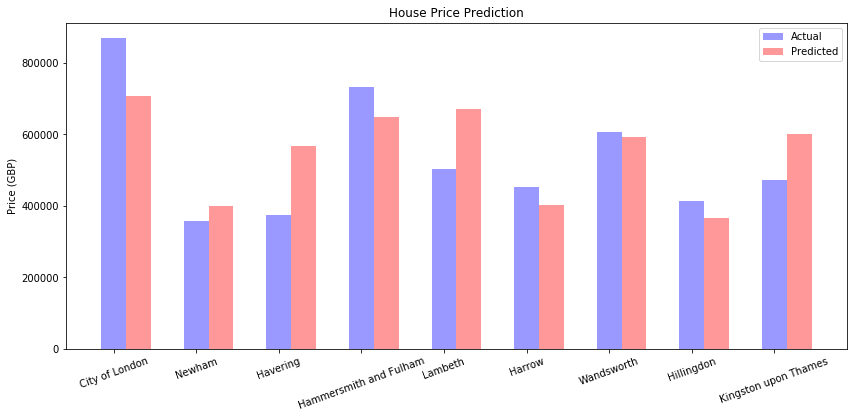

In [124]:
#Create bar plot
fig, ax = plt.subplots()
index = np.arange(0,y_compare.shape[0])
bar_width = 0.30
opacity = 0.4

rects1 = ax.bar(index, y_compare['Actual Price'], bar_width,
                alpha=opacity, color='b',               
                label='Actual')

rects2 = ax.bar(index + bar_width, y_compare['Predicted Price'], bar_width,
                alpha=opacity, color='r',               
                label='Predicted')

fig.set_figheight(6)
fig.set_figwidth(14)
plt.xticks(x_pos, y_compare['Region Name'],rotation=20)
plt.ylabel('Price (GBP)')
plt.title('House Price Prediction')
ax.legend() 
plt.show()

The bar graph shows how well the model predicted the house prices for the 9 London Boroughs from the test set. While the model performed admirably there were large descrepencies for 2 London Boroughs, Havering and Lambeth.

## Results & Discussion

The results gave valuable insight into the varying impacts of the different venue types on house prices. Pubs had the most detrimental impact, reducing the expected house value by £14k. As predicted in the introduction, Night Clubs adversely affected house price but was only the 6th worse venue category. While on the other end of the spectrum, Spa had an incredible positive impact adding £29k to the house price in the model. One important point, is that while a nearby Spa may add value to nearby house prices, the more likely scenario is that the Spa owners positioned themselves in wealthy areas. 

The model was also able to predict house price based only on nearby venues. This was demonstated on the test set. This was moderately effective, achieving an r2 score of 0.49. 

## Conclusion

The purpose of the project was to identify how nearby venues impact the house prices in London. While I have produced this information there are many considerations to be taken into account before relying on this data. The analysis on the test data showed that while model provided a good estimation, there was plenty of room for improvement.

First and foremost, there are many other variables that could influence house prices. For example, employment rates, house income, crime rates, the quality of schools and transport etc. So there will always be some limitations with only using nearby venue data as a model.

Secondly, due to limitiations with the Geopy library, I used summarised house price data rather than individual house sales. I suspect that unsummarised data would improve the model as the location and venue data will be more accurate.

Overall, I would say the model could used as a useful tool when used in conjunction with other information.